In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import mplfinance as mpf
from typing import Any

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

plt.rcParams['figure.dpi'] == 300
sns.set_style('whitegrid')
%matplotlib inline

In [37]:
# getting the data from yfinance
df = yf.Ticker('AAPL').history(start="1990-01-01")
df.columns = df.columns.str.lower()
df.shape

(8689, 7)

In [38]:
display(df.head(), df.tail())

,open,high,low,close,volume,dividends,stock splits
Date,,,,,,,
1990-01-02 00:00:00-05:00,0.248616,0.264485,0.246853,0.262722,183198400,0.0,0.0
1990-01-03 00:00:00-05:00,0.268012,0.268012,0.264485,0.264485,207995200,0.0,0.0
1990-01-04 00:00:00-05:00,0.269775,0.273301,0.262721,0.265367,221513600,0.0,0.0
1990-01-05 00:00:00-05:00,0.266248,0.269775,0.260958,0.266248,123312000,0.0,0.0
1990-01-08 00:00:00-05:00,0.264485,0.268012,0.260959,0.268012,101572800,0.0,0.0


,open,high,low,close,volume,dividends,stock splits
Date,,,,,,,
2024-06-24 00:00:00-04:00,207.720001,212.699997,206.589996,208.139999,80727000,0.0,0.0
2024-06-25 00:00:00-04:00,209.149994,211.380005,208.610001,209.070007,56713900,0.0,0.0
2024-06-26 00:00:00-04:00,211.500000,214.860001,210.639999,213.250000,66213200,0.0,0.0
2024-06-27 00:00:00-04:00,214.690002,215.740005,212.350006,214.100006,49772700,0.0,0.0
2024-06-28 00:00:00-04:00,215.770004,216.070007,210.300003,210.619995,82475600,0.0,0.0


In [39]:
df.describe()

,open,high,low,close,volume,dividends,stock splits
count,8689.000000,8689.000000,8689.000000,8689.000000,8.689000e+03,8689.000000,8689.000000
mean,26.636586,26.923927,26.362685,26.653826,3.601063e+08,0.000951,0.001726
std,48.820829,49.346688,48.334722,48.859360,3.589458e+08,0.013216,0.091648
min,0.097189,0.100020,0.096245,0.097661,2.396800e+06,0.000000,0.000000
25%,0.316247,0.322758,0.308892,0.316138,1.286616e+08,0.000000,0.000000
50%,2.690351,2.742589,2.643248,2.689446,2.418360e+08,0.000000,0.000000
75%,25.332992,25.595953,25.048950,25.392517,4.558568e+08,0.000000,0.000000
max,217.589996,220.199997,213.000000,216.669998,7.421641e+09,0.250000,7.000000


### Inference of the features
- Open: The price at which the stock starts trading when the market opens.
- High: The highest price at which the stock is traded during the trading day.
- Low: The lowest price at which the stock is traded during the trading day.
- Close: The price at which the stock stops trading when the market closes.
- Volume: The total number of shares traded during the trading day.
- Dividends: Payments made to shareholders, usually from company profits, typically on a per-share basis.
- Stock Splits: An adjustment in the number of a company’s shares, either increasing (split) or decreasing (reverse split) the number of shares, without changing the company's total market value.

## Plotting the line plot for each feature

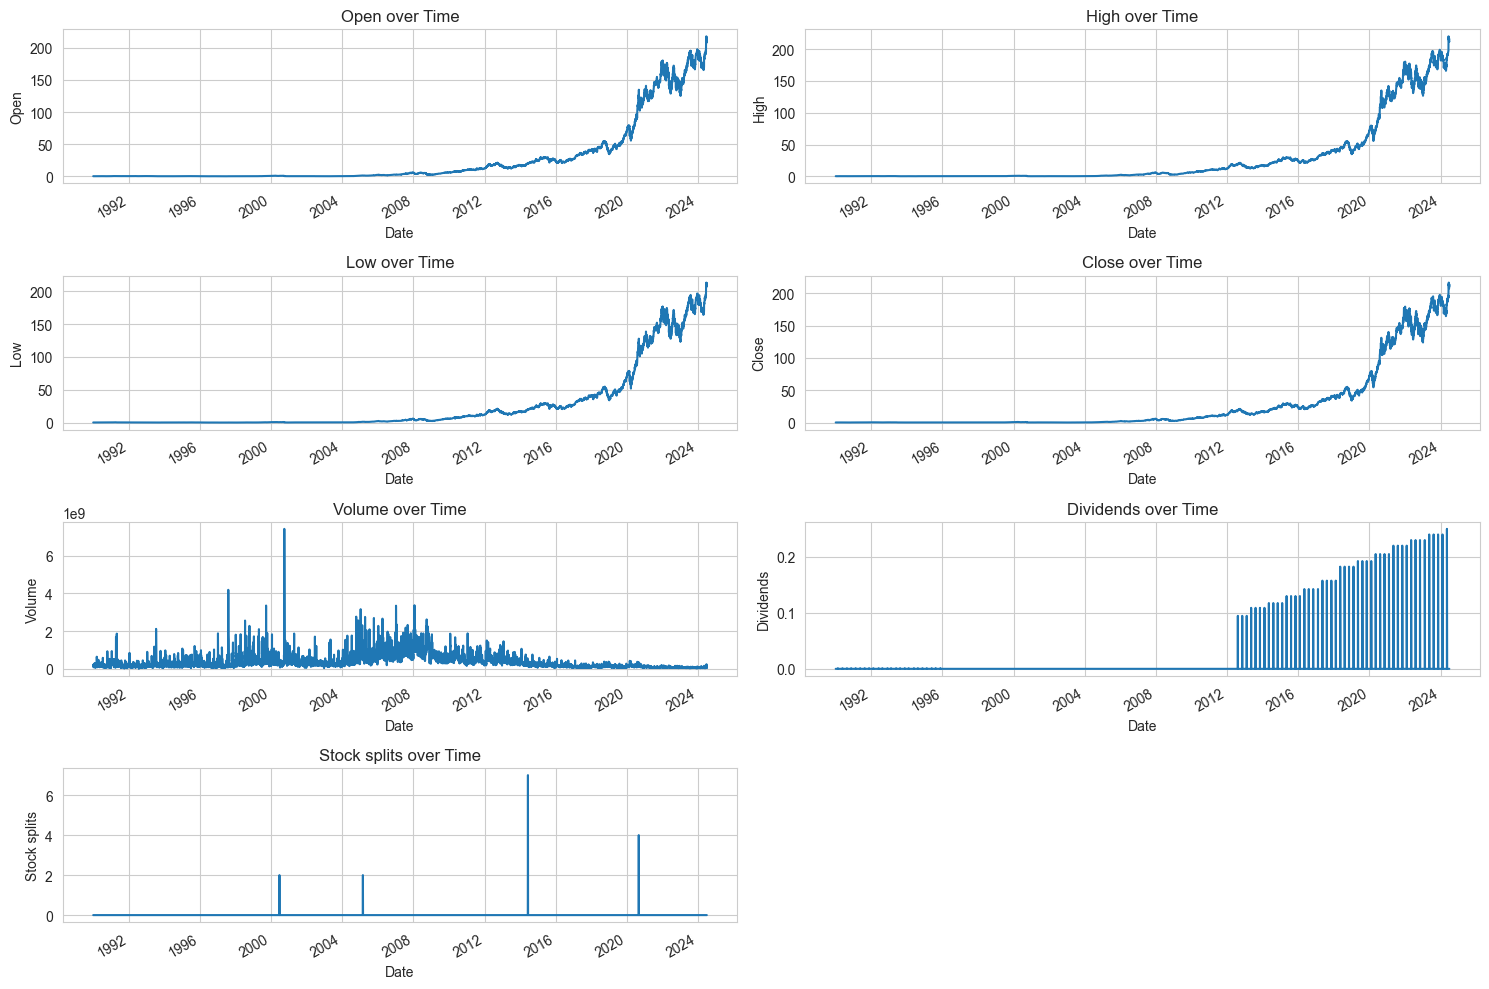

In [40]:
columns = df.describe().columns.to_list()

n_cols = 2
n_rows = (len(columns) + n_cols - 1) // n_cols 
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
axes = axes.flatten() 

for i, column in enumerate(columns):
    df[column].plot(ax=axes[i])
    axes[i].set_title(f'{column.capitalize()} over Time')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(column.capitalize())

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

- For the `Open`, `Close`, `Low` and `High` the trends are showing an upward trend
- `Volume` had more variance __before 2016__ and since then it has been not that varied
- `Dividends` started after after the __start of 2012__ and has been growing consistently

## Plotting histograms for each metric

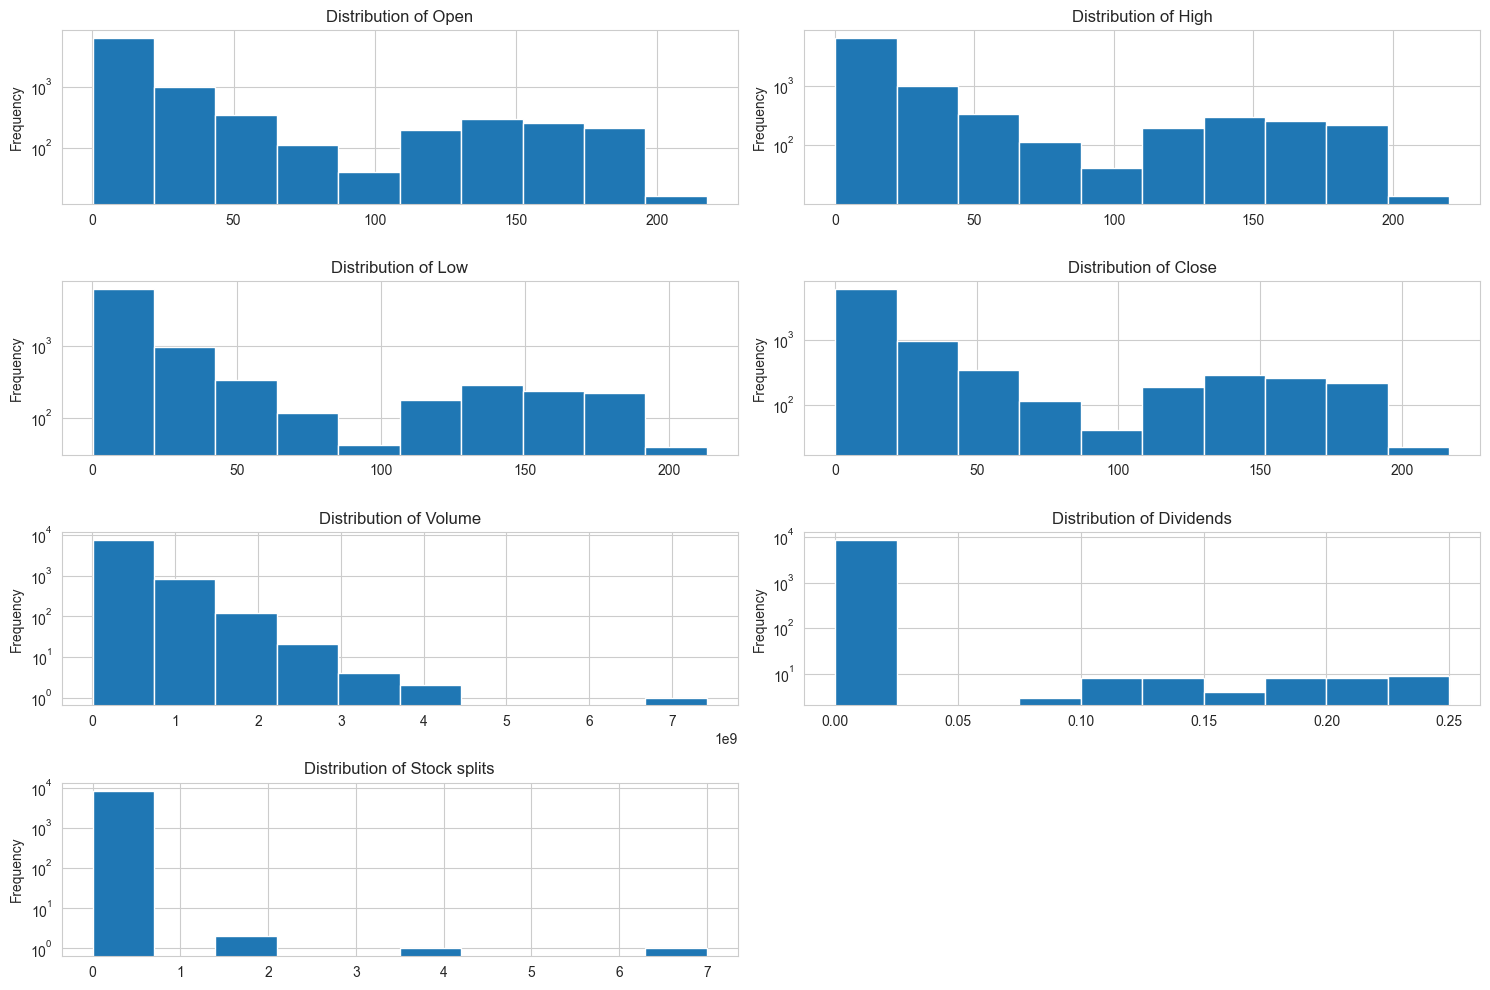

In [41]:
columns = df.describe().columns.to_list()

n_cols = 2
n_rows = (len(columns) + n_cols - 1) // n_cols 
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
axes = axes.flatten() 

for i, column in enumerate(columns):
    df[column].plot(kind='hist', ax=axes[i])
    axes[i].set_title(f'Distribution of {column.capitalize()}')
    axes[i].set_yscale('log')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

- Once again the distribution of `Open`, `Close`, `Low` and `High` are very similiar to each other.
- The volume appears to be right skewed with no values in __4,5 and 6 bins__

## Candle Stick Chart

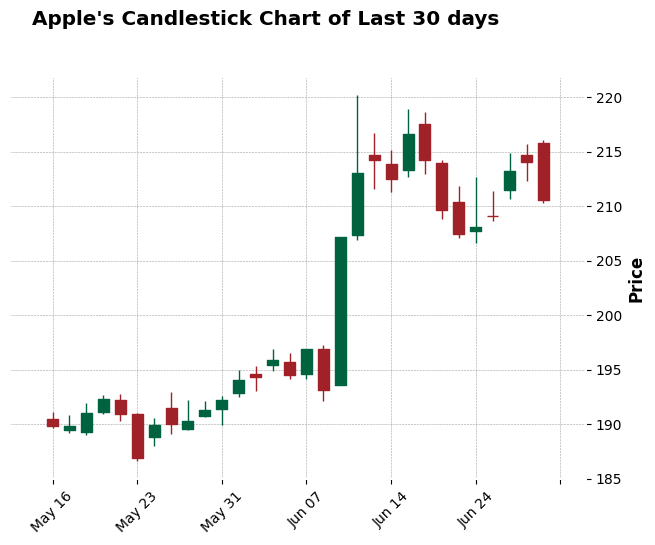

In [42]:
mpf.plot(df[-30:], type='candle', style='charles', title="Apple's Candlestick Chart of Last 30 days", ylabel='Price')

## Correlation heatmap plot

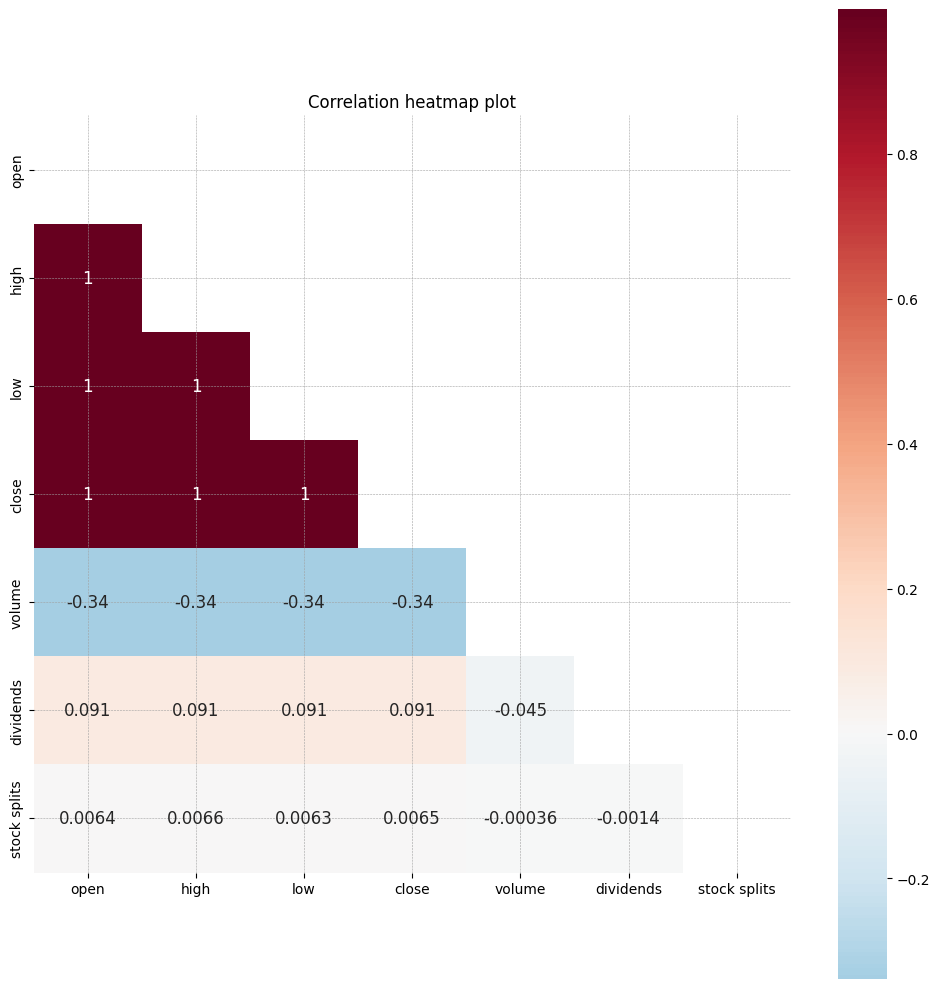

In [43]:
# Creating a heatmap correlation plot
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df.corr(), mask=mask, cmap='RdBu_r', annot=True, 
            center=0, square=True, annot_kws={'size':12})
plt.title("Correlation heatmap plot")
plt.tight_layout()
plt.show()

In [44]:
# dropping dividend and stock split as we won't be needing them to predict the stock trend
df.shape
df = df.drop(columns=['dividends','stock splits'])
df.shape

(8689, 5)

In [45]:
df.sample(5)

,open,high,low,close,volume
Date,,,,,
2021-10-18 00:00:00-04:00,141.250743,144.588770,140.965196,144.303223,85589200
1999-06-03 00:00:00-04:00,0.353845,0.362336,0.353373,0.358091,488510400
2005-07-28 00:00:00-04:00,1.324039,1.328569,1.307433,1.322530,251311200
2001-04-23 00:00:00-04:00,0.367470,0.377435,0.362337,0.366112,541525600
2023-11-09 00:00:00-05:00,182.239258,183.394677,181.093779,181.691422,53763500


## Feature Engineering

In [46]:
# creating a column that stores the value of the closing price of the next day
df['tomorrow'] = df['close'].shift(-1)
df.head()

,open,high,low,close,volume,tomorrow
Date,,,,,,
1990-01-02 00:00:00-05:00,0.248616,0.264485,0.246853,0.262722,183198400,0.264485
1990-01-03 00:00:00-05:00,0.268012,0.268012,0.264485,0.264485,207995200,0.265367
1990-01-04 00:00:00-05:00,0.269775,0.273301,0.262721,0.265367,221513600,0.266248
1990-01-05 00:00:00-05:00,0.266248,0.269775,0.260958,0.266248,123312000,0.268012
1990-01-08 00:00:00-05:00,0.264485,0.268012,0.260959,0.268012,101572800,0.265367


In [47]:
# creating a flag column that checks of the tomorrow price is greater than today (i.e. upwards trend) as 1 else (i.e. downwards trend) as 0
df['target'] = np.where(df['tomorrow'] > df['close'], 1, 0)
df.sample(5)

,open,high,low,close,volume,tomorrow,target
Date,,,,,,,
2005-08-03 00:00:00-04:00,1.304111,1.307734,1.291429,1.305016,258322400,1.289617,0
2021-01-27 00:00:00-05:00,140.570573,141.423239,137.610790,139.227890,140843800,134.356964,0
2002-03-04 00:00:00-05:00,0.351165,0.371094,0.343617,0.366715,348258400,0.355242,0
2004-09-24 00:00:00-04:00,0.565397,0.573700,0.560867,0.562981,369488000,0.566605,1
2008-07-01 00:00:00-04:00,4.958882,5.275625,4.951938,5.274417,1111280800,5.078153,0


## Model Training

In [48]:
# splitting the data into train and test sets
train = df.iloc[:-100]
test = df.iloc[-100:]
assert train.shape[0] + test.shape[0] == df.shape[0]
assert train.index.intersection(test.index).empty == True

In [49]:
display(train.tail(), test.tail())
print(f"Shape of training data: {train.shape}\nShape of testing data: {test.shape}")

,open,high,low,close,volume,tomorrow,target
Date,,,,,,,
2024-01-30 00:00:00-05:00,190.438365,191.296106,186.977480,187.545975,55859400,183.915543,0
2024-01-31 00:00:00-05:00,186.548606,186.608461,183.865686,183.915543,55467800,186.369095,1
2024-02-01 00:00:00-05:00,183.506640,186.458855,183.337088,186.369095,64885400,185.361740,0
2024-02-02 00:00:00-05:00,179.387472,186.837848,178.779074,185.361740,102518000,187.186920,1
2024-02-05 00:00:00-05:00,187.655687,188.752803,185.351758,187.186920,69668800,188.802673,1


,open,high,low,close,volume,tomorrow,target
Date,,,,,,,
2024-06-24 00:00:00-04:00,207.720001,212.699997,206.589996,208.139999,80727000,209.070007,1
2024-06-25 00:00:00-04:00,209.149994,211.380005,208.610001,209.070007,56713900,213.250000,1
2024-06-26 00:00:00-04:00,211.500000,214.860001,210.639999,213.250000,66213200,214.100006,1
2024-06-27 00:00:00-04:00,214.690002,215.740005,212.350006,214.100006,49772700,210.619995,0
2024-06-28 00:00:00-04:00,215.770004,216.070007,210.300003,210.619995,82475600,NaN,0


Shape of training data: (8589, 7)
Shape of testing data: (100, 7)


In [50]:
# picking the features we want to use
predictors = ['open', 'close', 'high', 'low', 'volume']

# fitting the model
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=42)
model.fit(train[predictors], train['target'])

RandomForestClassifier(min_samples_split=100, random_state=42)

In [52]:
# predicting using the testing data
pred = model.predict(test[predictors])

# checking the model precision
pred = pd.Series(pred, index= test.index)
precision_score(test['target'], pred)

0.5208333333333334

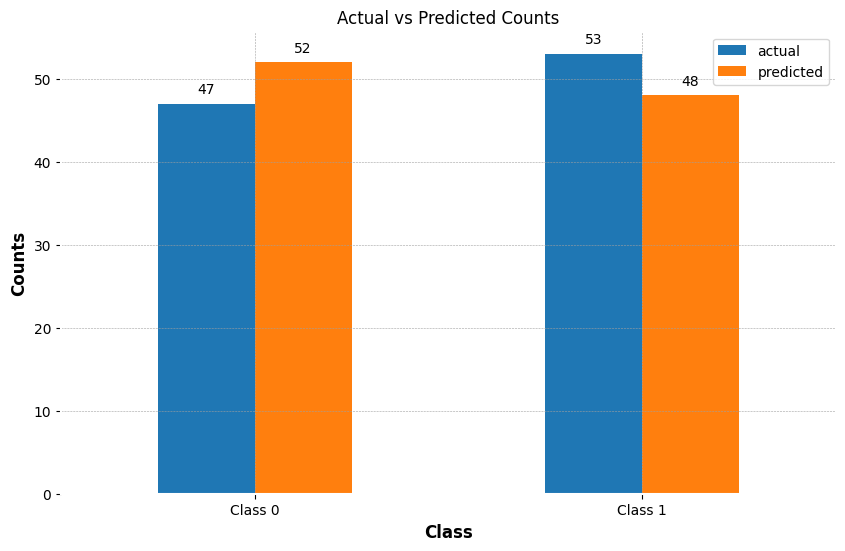

In [53]:
# creating barplot to visualise the actual vs predicted
combined = pd.concat([test["target"], pred], axis=1)
combined.columns = ["actual", "predicted"]

counts = combined.apply(pd.Series.value_counts)

ax = counts.plot(kind='bar', figsize=(10, 6))
plt.title('Actual vs Predicted Counts')
plt.xlabel('Class')
plt.ylabel('Counts')
plt.xticks(ticks=[0, 1], labels=['Class 0', 'Class 1'], rotation=0)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', 
                xytext=(0, 5), textcoords='offset points')

plt.show()

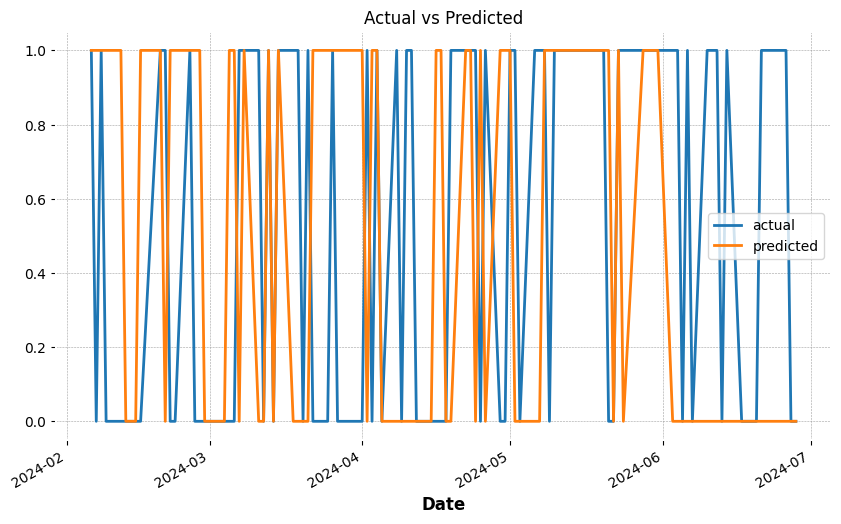

In [54]:
# ploting predictions
combined.plot(figsize=(10,6))
plt.title("Actual vs Predicted")
plt.show()

# Implementation of Back testing

In [55]:
def predict(train: pd.DataFrame, 
            test: pd.DataFrame, 
            predictors: list, 
            model: Any
) -> pd.DataFrame:
    """
    This function is used to make predictions on a test dataset using a trained model.
    
    Parameters:
    - train (pd.DataFrame): The training dataset with features and target variable.
    - test (pd.DataFrame): The testing dataset with features only.
    - predictors (list): A list of column names used as predictors.
    - model (Any): The trained model to make predictions.
    
    Returns:
    - pd.DataFrame: A DataFrame containing the actual target values and the predicted values.
    """
    model.fit(train[predictors], train['target'])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name='predictions')
    combined = pd.concat([test['target'], preds], axis=1)
    
    return combined

In [56]:
def backtest(df: pd.DataFrame, 
             model: Any, 
             predictors: list, 
             start: int = 2500, 
             step: int = 250
) -> pd.DataFrame: 
    """
    This function is used to perform a backtesting process on a given DataFrame using a trained model.
    The function iterates through the DataFrame, making predictions at each step and appending them to a list.
    Finally, it returns a DataFrame containing all the predictions made during the backtesting process.

    Parameters:
    - df (pd.DataFrame): The input DataFrame containing the historical data.
    - model (Any): The trained model to make predictions.
    - predictors (list): A list of column names used as predictors.
    - start (int): The starting index for the backtesting process. Default is 2500.
    - step (int): The number of rows to use for each backtesting iteration. Default is 250.

    Returns:
    - pd.DataFrame: A DataFrame containing the predictions for each iteration.
    """
    all_prediction = list()
    
    for i in range (start, df.shape[0], step):
        train = df.iloc[0:i].copy()
        test = df.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_prediction.append(predictions)
        
    return pd.concat(all_prediction)

In [57]:
predictions = backtest(df, model, predictors)

In [58]:
predictions['predictions'].value_counts()

predictions
0    4233
1    1956
Name: count, dtype: int64

In [59]:
precision_score(predictions['target'], predictions['predictions'])

0.5194274028629857

# Feature Engineering 

In [60]:
# defining horizons
# 2 -> two days
# 5 -> one week
# 60 -> three months
# 1000 -> 4 years
horizons = [2, 5, 60, 250, 1_000,]
new_predictions = list()

for horizon in horizons:
    rolling_averages = df.rolling(horizon).mean()
    
    ratio_column = f"close_ratio_{horizon}"
    df[ratio_column] = df['close'] / rolling_averages['close']
    
    trend_column = f"trend_{horizon}"
    df[trend_column] = df.shift(1).rolling(horizon).sum()['target']
    
    new_predictions += [ratio_column, trend_column]

In [61]:
display(df.shape)
df = df.dropna(subset=df.columns[df.columns != 'tomorrow'])
display(df.shape)

(8689, 17)

(7689, 17)

In [62]:
df.head()

,open,high,low,close,volume,tomorrow,target,close_ratio_2,trend_2,close_ratio_5,trend_5,close_ratio_60,trend_60,close_ratio_250,trend_250,close_ratio_1000,trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14 00:00:00-05:00,0.215274,0.218954,0.213435,0.214355,293664000,0.218954,1,0.993604,1.0,0.978993,1.0,1.007241,22.0,0.694752,111.0,0.637247,462.0
1993-12-15 00:00:00-05:00,0.213435,0.218954,0.213435,0.218954,123883200,0.216194,0,1.010615,1.0,1.014493,2.0,1.025699,23.0,0.711547,111.0,0.651010,462.0
1993-12-16 00:00:00-05:00,0.217114,0.218954,0.213435,0.216194,126369600,0.217114,1,0.993658,1.0,1.005994,2.0,1.010468,22.0,0.704569,110.0,0.642898,461.0
1993-12-17 00:00:00-05:00,0.217114,0.218954,0.214355,0.217114,145152000,0.209754,0,1.002123,1.0,1.001698,3.0,1.011960,23.0,0.709636,110.0,0.645728,461.0
1993-12-20 00:00:00-05:00,0.215274,0.218954,0.207914,0.209754,189033600,0.202395,0,0.982758,1.0,0.974357,2.0,0.975652,22.0,0.687598,110.0,0.623946,460.0


# Developing the model using the newly created features

In [63]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=42)

In [74]:
def predict(train: pd.DataFrame, 
            test: pd.DataFrame, 
            predictors: list, 
            model: Any,
            threshold: float = 0.6
) -> pd.DataFrame:
    """
    This function is used to make predictions on a test dataset using a trained model.
    
    Parameters:
    - train (pd.DataFrame): The training dataset with features and target variable.
    - test (pd.DataFrame): The testing dataset with features only.
    - predictors (list): A list of column names used as predictors.
    - model (Any): The trained model to make predictions.
    - threshold (float): The cut off value for the classification (default is 0.5)
    
    Returns:
    - pd.DataFrame: A DataFrame containing the actual target values and the predicted values using predict proba
    while using threshold as 0.6.
    """
    model.fit(train[predictors], train['target'])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >= threshold] = 1
    preds[preds < threshold] = 0
    preds = pd.Series(preds, index=test.index, name='predictions')
    combined = pd.concat([test['target'], preds], axis=1)
    
    return combined

In [75]:
predictions = backtest(df, model, new_predictions)

In [76]:
predictions['predictions'].value_counts()

predictions
0.0    4679
1.0     510
Name: count, dtype: int64

In [77]:
precision_score(predictions['target'], predictions['predictions'])

0.5529411764705883

In [68]:
predictions['predictions'].value_counts(normalize=True)

predictions
0.0    0.901715
1.0    0.098285
Name: proportion, dtype: float64

In [69]:
predictions

,target,predictions
Date,,
2003-11-14 00:00:00-05:00,0,0.0
2003-11-17 00:00:00-05:00,0,0.0
2003-11-18 00:00:00-05:00,1,0.0
2003-11-19 00:00:00-05:00,0,0.0
2003-11-20 00:00:00-05:00,0,0.0
...,...,...
2024-06-24 00:00:00-04:00,1,0.0
2024-06-25 00:00:00-04:00,1,0.0
2024-06-26 00:00:00-04:00,1,0.0
